- Handling warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")

- Loading modules

In [2]:
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import numpy as np
import shap
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
plt.rc('font', size=12)

- Auxiliar functions

In [4]:
def get_metrics(y_true, y_predict, method):
    metrics_estimated = {
        "Method" : method,
        "Accuracy" : accuracy_score(y_true=y_true, y_pred=y_predict),
        "Precision" : precision_score(y_true=y_true, y_pred=y_predict),
        "Recall" : recall_score(y_true=y_true, y_pred=y_predict),
        "F1-score" : f1_score(y_true=y_true, y_pred=y_predict),
        "MCC" : matthews_corrcoef(y_true=y_true, y_pred=y_predict)
    }
    return metrics_estimated

In [5]:
def apply_model(model, X_train, X_test, X_val, y_train, y_val, y_test, name_model):
    model.fit(X=X_train, y=y_train)
    model_prediction_val = model.predict(X=X_val)
    model_prediction_test = model.predict(X=X_test)

    performances_val = get_metrics(y_true=y_val, y_predict=model_prediction_val, method=name_model)
    performances_test = get_metrics(y_true=y_test, y_predict=model_prediction_test, method=name_model)

    return model, performances_val, performances_test

- Preprocessing dataset

In [6]:
df_data = pd.read_csv("../processed_data/1_processed_data_IgA.csv")
df_data.head(5)

,ID,Gender,age_baby_1,age_baby_2,age_baby_5,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference,sIgA_Average_Morning_log,sIgA_Average_Afternoon_log,sIgA_Average_Difference_log,Attachment
0,1,Male,5,7.0,15.0,21.765240,28.368055,6.602815,3.077296,3.338237,0.260941,Insecure
1,4,Male,10,10.0,16.0,28.473065,50.881961,22.408896,3.348951,3.687484,0.338533,Secure
2,5,Female,5,NaN,14.0,161.424693,46.867951,-114.556742,5.084039,3.847334,-1.236705,Secure
3,7,Female,12,12.0,18.0,24.173487,35.942378,14.343241,3.179553,3.581917,0.402364,Insecure
4,11,Male,8,9.0,NaN,78.013279,382.715268,345.590046,4.196295,5.947291,1.750996,Insecure


In [7]:
df_data.shape

(35, 12)

In [8]:
df_data.columns

Index(['ID', 'Gender', 'age_baby_1', 'age_baby_2', 'age_baby_5',
       'sIgA_Average_Morning', 'sIgA_Average_Afternoon',
       'sIgA_Average_Difference', 'sIgA_Average_Morning_log',
       'sIgA_Average_Afternoon_log', 'sIgA_Average_Difference_log',
       'Attachment'],
      dtype='object')

In [9]:
df_data = df_data[['Gender', 'sIgA_Average_Morning_log', 'sIgA_Average_Afternoon_log',
       'sIgA_Average_Difference_log', 'Attachment', 'ID']]
df_data = df_data.dropna()
df_data["Attachment"] = df_data["Attachment"].replace({"Insecure": 1, "Secure":0, "Unknown":2})
print(df_data.shape)
df_data.head(5)

(35, 6)


,Gender,sIgA_Average_Morning_log,sIgA_Average_Afternoon_log,sIgA_Average_Difference_log,Attachment,ID
0,Male,3.077296,3.338237,0.260941,1,1
1,Male,3.348951,3.687484,0.338533,0,4
2,Female,5.084039,3.847334,-1.236705,0,5
3,Female,3.179553,3.581917,0.402364,1,7
4,Male,4.196295,5.947291,1.750996,1,11


In [10]:
df_data["Gender"] = df_data["Gender"].replace({"Female":0, "Male": 1})

In [11]:
response = df_data["Attachment"].values
df_for_training = df_data.drop(columns=['Attachment', 'ID'])

- Apply standardization process

In [12]:
scaler_instance = MinMaxScaler()
scaler_instance.fit(df_for_training.values)
scaled_data = scaler_instance.transform(df_for_training.values)

df_prepared = pd.DataFrame(data=scaled_data, columns=df_for_training.columns)
df_prepared["Attachment"] = response
df_prepared.head(5)

,Gender,sIgA_Average_Morning_log,sIgA_Average_Afternoon_log,sIgA_Average_Difference_log,Attachment
0,1.0,0.132332,0.145915,0.472823,1
1,1.0,0.249789,0.260242,0.497320,0
2,0.0,1.000000,0.312570,0.000000,0
3,0.0,0.176546,0.225685,0.517472,1
4,1.0,0.616161,1.000000,0.943250,1


- Using SMOTE for data augmentation

In [13]:
X = df_prepared.drop(columns=['Attachment'])
y = df_prepared['Attachment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)
print(y_test.shape, y_train.shape)

(9,) (26,)


- 100 per class will be generated

In [14]:
smote = SMOTE(
    random_state=42,
    sampling_strategy={1: 100, 0: 100})

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled["Gender"] = X_train_resampled["Gender"].apply(lambda x: 1 if x > 0.5 else 0)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.3, stratify=y_train_resampled, random_state=42
)

In [16]:
X_train.head()

,Gender,sIgA_Average_Morning_log,sIgA_Average_Afternoon_log,sIgA_Average_Difference_log
0,1,0.249789,0.260242,0.497320
148,1,0.321798,0.636783,0.807889
141,1,0.180553,0.042630,0.338002
91,1,0.290953,0.113561,0.325799
188,1,0.175473,0.077463,0.375306


In [17]:
X_val.head()

,Gender,sIgA_Average_Morning_log,sIgA_Average_Afternoon_log,sIgA_Average_Difference_log
19,1,0.616161,1.000000,0.943250
24,0,0.336570,0.060714,0.241523
15,1,0.065128,0.207689,0.581471
136,0,0.072732,0.332067,0.695873
133,0,0.213661,0.253973,0.517654


In [18]:
X_train.shape

(140, 4)

In [19]:
X_val.shape

(60, 4)

In [20]:
X_test.shape

(9, 4)

- Training models and get metrics

In [21]:
lr_model, lr_performances_val, lr_performances_test = apply_model(LogisticRegression(random_state=42), X_train, X_test, X_val, y_train, y_val, y_test, "LogisticRegression")
rf_model, rf_performances_val, rf_performances_test = apply_model(RandomForestClassifier(random_state=42), X_train, X_test, X_val, y_train, y_val, y_test, "RandomForestClassifier")
knn_model, knn_performances_val, knn_performances_test = apply_model(KNeighborsClassifier(), X_train, X_test, X_val, y_train, y_val, y_test, "KNeighborsClassifier")
dt_model, dt_performances_val, dt_performances_test = apply_model(DecisionTreeClassifier(random_state=42), X_train, X_test, X_val, y_train, y_val, y_test, "DecisionTreeClassifier")
svm_model, svm_performances_val, svm_performances_test = apply_model(SVC(random_state=42), X_train, X_test, X_val, y_train, y_val, y_test, "SVC")
adaboost_model, adaboost_performances_val, adaboost_performances_test = apply_model(AdaBoostClassifier(random_state=42), X_train, X_test, X_val, y_train, y_val, y_test, "AdaBoostClassifier")
xgboost_model, xgboost_performances_val, xgboost_performances_test = apply_model(XGBClassifier(), X_train, X_test, X_val, y_train, y_val, y_test, "XGBClassifier")
lgbm_model, lgbm_performances_val, lgbm_performances_test = apply_model(LGBMClassifier(random_state=42), X_train, X_test, X_val, y_train, y_val, y_test, "LGBMClassifier")
gradient_model, gradient_performances_val, gradient_performances_test = apply_model(GradientBoostingClassifier(random_state=42), X_train, X_test, X_val, y_train, y_val, y_test, "GradientBoostingClassifier")
naive_model, naive_performances_val, naive_performances_test = apply_model(GaussianNB(), X_train, X_test, X_val, y_train, y_val, y_test, "GaussianNB")
gaussian_process_model, gaussian_process_performances_val, gaussian_process_performances_test = apply_model(GaussianProcessClassifier(random_state=42), X_train, X_test, X_val, y_train, y_val, y_test, "GaussianProcessClassifier")
bagging_process_model, bagging_process_performances_val, bagging_process_performances_test = apply_model(BaggingClassifier(random_state=42), X_train, X_test, X_val, y_train, y_val, y_test, "BaggingClassifier")


[LightGBM] [Info] Number of positive: 70, number of negative: 70
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146
[LightGBM] [Info] Number of data points in the train set: 140, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

- Making summary of performances

In [22]:
data_performances_val = [
    lr_performances_val,
    knn_performances_val,
    dt_performances_val,
    rf_performances_val,
    adaboost_performances_val,
    gradient_performances_val,
    svm_performances_val,
    xgboost_performances_val,
    lgbm_performances_val,
    bagging_process_performances_val,
    naive_performances_val,
    gaussian_process_performances_val
]

df_perfomances_val = pd.DataFrame(data_performances_val)
df_perfomances_val

,Method,Accuracy,Precision,Recall,F1-score,MCC
0,LogisticRegression,0.666667,0.656250,0.700000,0.677419,0.334077
1,KNeighborsClassifier,0.750000,0.758621,0.733333,0.745763,0.500278
2,DecisionTreeClassifier,0.866667,0.923077,0.800000,0.857143,0.739940
3,RandomForestClassifier,0.900000,1.000000,0.800000,0.888889,0.816497
4,AdaBoostClassifier,0.833333,0.884615,0.766667,0.821429,0.672673
5,GradientBoostingClassifier,0.883333,0.960000,0.800000,0.872727,0.777542
6,SVC,0.683333,0.666667,0.733333,0.698413,0.368514
7,XGBClassifier,0.850000,0.888889,0.800000,0.842105,0.703526
8,LGBMClassifier,0.900000,0.961538,0.833333,0.892857,0.807207
9,BaggingClassifier,0.883333,1.000000,0.766667,0.867925,0.788430


In [23]:
df_perfomances_val.sort_values(by="MCC", ascending=False)

,Method,Accuracy,Precision,Recall,F1-score,MCC
3,RandomForestClassifier,0.900000,1.000000,0.800000,0.888889,0.816497
8,LGBMClassifier,0.900000,0.961538,0.833333,0.892857,0.807207
9,BaggingClassifier,0.883333,1.000000,0.766667,0.867925,0.788430
5,GradientBoostingClassifier,0.883333,0.960000,0.800000,0.872727,0.777542
2,DecisionTreeClassifier,0.866667,0.923077,0.800000,0.857143,0.739940
7,XGBClassifier,0.850000,0.888889,0.800000,0.842105,0.703526
4,AdaBoostClassifier,0.833333,0.884615,0.766667,0.821429,0.672673
1,KNeighborsClassifier,0.750000,0.758621,0.733333,0.745763,0.500278
10,GaussianNB,0.733333,0.705882,0.800000,0.750000,0.470871
6,SVC,0.683333,0.666667,0.733333,0.698413,0.368514


In [24]:
data_performances_test = [
lr_performances_test,
    knn_performances_test,
    dt_performances_test,
    rf_performances_test,
    adaboost_performances_test,
    gradient_performances_test,
    svm_performances_test,
    xgboost_performances_test,
    lgbm_performances_test,
    bagging_process_performances_test,
    naive_performances_test,
    gaussian_process_performances_test
]

df_perfomances_test = pd.DataFrame(data_performances_test)
df_perfomances_test

,Method,Accuracy,Precision,Recall,F1-score,MCC
0,LogisticRegression,0.555556,0.500000,0.25,0.333333,0.059761
1,KNeighborsClassifier,0.444444,0.000000,0.00,0.000000,-0.316228
2,DecisionTreeClassifier,0.666667,1.000000,0.25,0.400000,0.395285
3,RandomForestClassifier,0.666667,1.000000,0.25,0.400000,0.395285
4,AdaBoostClassifier,0.555556,0.000000,0.00,0.000000,0.000000
5,GradientBoostingClassifier,0.555556,0.000000,0.00,0.000000,0.000000
6,SVC,0.444444,0.333333,0.25,0.285714,-0.158114
7,XGBClassifier,0.666667,1.000000,0.25,0.400000,0.395285
8,LGBMClassifier,0.444444,0.000000,0.00,0.000000,-0.316228
9,BaggingClassifier,0.555556,0.000000,0.00,0.000000,0.000000


In [25]:
df_perfomances_test.sort_values(by="MCC", ascending=False)

,Method,Accuracy,Precision,Recall,F1-score,MCC
3,RandomForestClassifier,0.666667,1.000000,0.25,0.400000,0.395285
2,DecisionTreeClassifier,0.666667,1.000000,0.25,0.400000,0.395285
7,XGBClassifier,0.666667,1.000000,0.25,0.400000,0.395285
0,LogisticRegression,0.555556,0.500000,0.25,0.333333,0.059761
10,GaussianNB,0.555556,0.500000,0.25,0.333333,0.059761
11,GaussianProcessClassifier,0.555556,0.500000,0.25,0.333333,0.059761
9,BaggingClassifier,0.555556,0.000000,0.00,0.000000,0.000000
4,AdaBoostClassifier,0.555556,0.000000,0.00,0.000000,0.000000
5,GradientBoostingClassifier,0.555556,0.000000,0.00,0.000000,0.000000
6,SVC,0.444444,0.333333,0.25,0.285714,-0.158114


In [26]:
def create_curve_roc(clf_model, train_data, train_response, axis):
    n_splits = 6
    cv = StratifiedKFold(n_splits=n_splits)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for fold, (train, test) in enumerate(cv.split(train_data, train_response)):

        
        clf_model.fit(train_data[train], train_response[train])
        viz = RocCurveDisplay.from_estimator(
            clf_model,
            train_data[test],
            train_response[test],
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=axis,
            plot_chance_level=(fold == n_splits - 1),
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    axis.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    axis.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    axis.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve with variability\n(Positive label)",
    )
    axis.legend(loc="lower right")

In [28]:
from joblib import dump

In [29]:
dump(rf_model, "../data_for_figures/rf_model.joblib")

['../data_for_figures/rf_model.joblib']

In [30]:
X_train_resampled.to_csv("../data_for_figures/data_figure_G_samples.csv", index=False)
y_train_resampled.to_csv("../data_for_figures/data_figure_G_labels.csv", index=False)

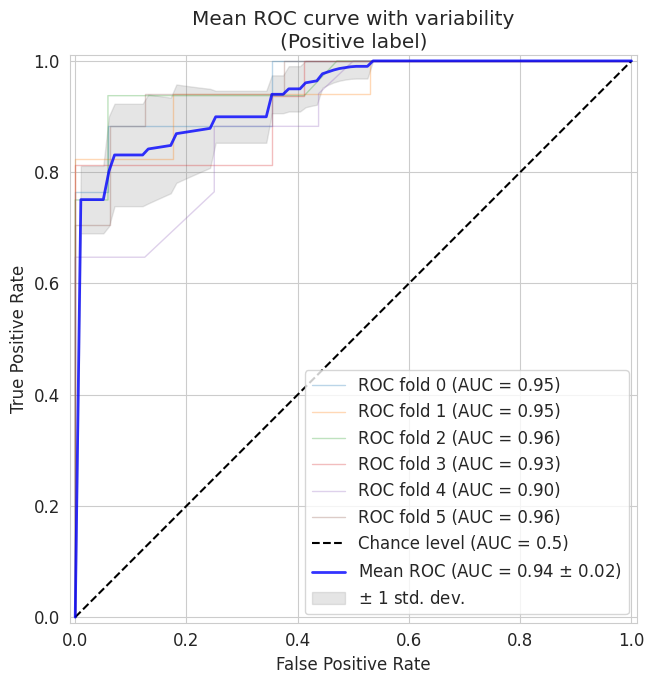

In [27]:
fig, axes = plt.subplots(1, 1, figsize=(10, 7))

create_curve_roc(rf_model, X_train_resampled.values, y_train_resampled.values, axes)

plt.tight_layout()